# Expected variants
This script determines the expected number of variants for a given region. 
It calculates this for:
- Transcripts
- NMD regions

## Import modules

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import r2_score
from scipy import stats as _stats

sns.set_context("talk")

## Load data

### Rare synonymous variants are the basis for the model

In [2]:
# Rare synonymous variants per variant context
syn = pd.read_csv("../outputs/observed_variants_stats_synonymous.tsv", sep="\t")

# Get proportion of variants observed
syn["prop_obs"] = syn["obs"] / syn["pos"]

# Exclude CpG transitions
syn_cpg = syn[syn["variant_type"] != "CpG"].copy()

### Transcripts and NMD regions

In [15]:
# Variants observed per transcript
enst = pd.read_csv("../outputs/observed_variants_stats_transcript_no_cpg.tsv", sep="\t")

In [16]:
# Variants observed per NMD region
nmd = pd.read_csv("../outputs/observed_variants_stats_nmd_no_cpg.tsv", sep="\t")

In [17]:
# Concatenate the transcript-level and region-level data
enst = enst.assign(region="transcript")
nmd = nmd.rename(columns={"nmd":"region"})

df = pd.concat([nmd, enst]).sort_values(["region","enst","csq"])

## Linear model for expected proportion of variants

From expecation_model_choices.ipynb, it seems the best model for predicting the expected number of variants (excluding CpG transitions) is a simple linear model of obs vs mu, weighted by the number of possible variants per context. 

In [24]:
# Linear model
fit = np.polyfit(syn_cpg["mu"], syn_cpg["prop_obs"], 1, w=syn_cpg["pos"])
lm_p = np.poly1d(fit)

## Calculate expected variants per transcript and context

In [25]:
def get_expected(df, prediction):
    """
    Get the expected proportion of variants per transcript and consequence.
    prediction is a lambda function used to predict the expected value.
    """
    df = (
        df.assign(
            prop_obs=lambda x: x["n_obs"] / x["n_pos"],
            se_prop_obs=lambda x: np.sqrt(
                (x["prop_obs"] * (1 - x["prop_obs"])) / x["n_pos"]
            ),
            prop_exp=prediction,
            se_prop_exp=lambda x: np.sqrt(
                (x["prop_exp"] * (1 - x["prop_exp"])) / x["n_pos"]
            ),
            n_exp=lambda x: np.round(x["n_pos"] * x["prop_exp"], 2),
            oe=lambda x: x["n_obs"] / x["n_exp"],
            oe_ci_upper=lambda x: (
                x["prop_obs"] + _stats.norm.ppf(0.975) * (x["se_prop_obs"])
            )
            / x["prop_exp"],
            ee_ci_lower=lambda x: (
                x["prop_exp"] - _stats.norm.ppf(0.975) * (x["se_prop_exp"])
            )
            / x["prop_exp"],
            oe_diff=lambda x: (x["oe"] - x["ee_ci_lower"]),
        )
        .set_index(["region","enst","csq"])
        .unstack(fill_value=0)
        .stack()
        .reset_index()
    )
    # Z scores and p-values
    df["z"] = df.apply(
        lambda x: (
            proportions_ztest(
                x["n_obs"],
                x["n_pos"],
                x["prop_exp"],
                alternative="smaller",
                prop_var=x["prop_exp"],
            )[0]
        ),
        axis=1,
    )
    df["p"] = df.apply(
        lambda x: proportions_ztest(
            x["n_obs"],
            x["n_pos"],
            x["prop_exp"],
            alternative="smaller",
            prop_var=x["prop_exp"],
        )[1],
        axis=1,
    )
    return df

In [26]:
%%capture 
# Ignore error messages

df = get_expected(df=df, prediction=lambda x: lm_p(x["mu"]))

## Plots

### Expected and observed variants per transcript

In [8]:
def plot_obs_exp_per_transcript(df):
    """Plot number observed vs number expected per transcript"""

    g = sns.lmplot(
        data=df[df.enst != "ENST00000589042"],  # Exclude TTN for visual clarity
        x="n_exp",
        y="n_obs",
        col="csq",
        col_order=["synonymous", "missense", "nonsense"],
        facet_kws={"sharex": False, "sharey": False},
        ci=None,
        robust=True,
    )
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Expected", "Observed")
    for ax in g.axes[0]:
        ax.axline((0, 0), (1, 1), color="grey", linestyle="--")
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle("Variants per transcript")

    return g

Text(0.5, 0.98, 'Variants per transcript (linear model)')

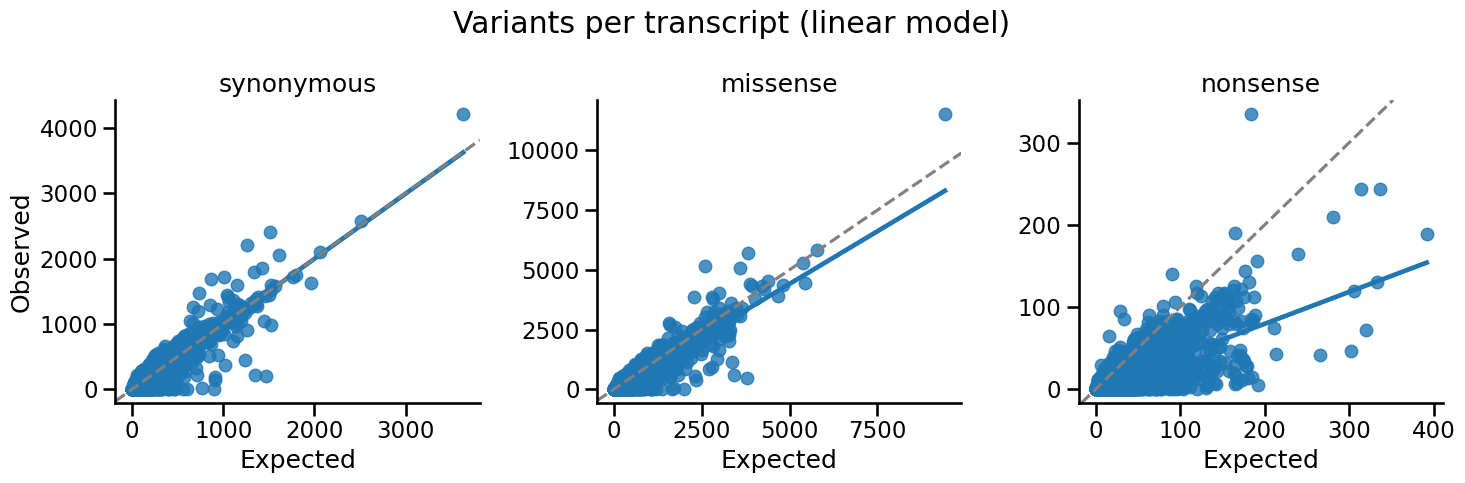

In [9]:
g = plot_obs_exp_per_transcript(enst_exp)
g.fig.suptitle("Variants per transcript (linear model)")

In [ ]:
lm.to_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t", index=False)

In [ ]:
dfg = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")